As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. 

The aim is to analyse the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyse the impact on player retention and game rounds.

In [81]:
import os

import numpy as np
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import shapiro
import scipy.stats as stats

import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

Data Description:

* userid: A unique number that identifies each player.
* version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40)
* sum_gamerounds: The number of game rounds played by the player during the first 14 days after install.
* retention_1: Did the player come back and play 1 day after installing?
* retention_7: Did the player come back and play 7 days after installing?

In [99]:
df = pd.read_csv("../Data/cookie_cats.csv")
display(df.head())
display(df.describe())
print(df.shape)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


(90189, 5)


In [100]:
df["retention"] = np.where((df["retention_1"]==True) & (df["retention_7"]==True), 1, 0)
df["version"] = np.where(df["version"]=="gate_30", "A", "B")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,retention
0,116,A,3,False,False,0
1,337,A,38,True,False,0
2,377,B,165,True,False,0
3,483,B,1,False,False,0
4,488,B,179,True,True,1


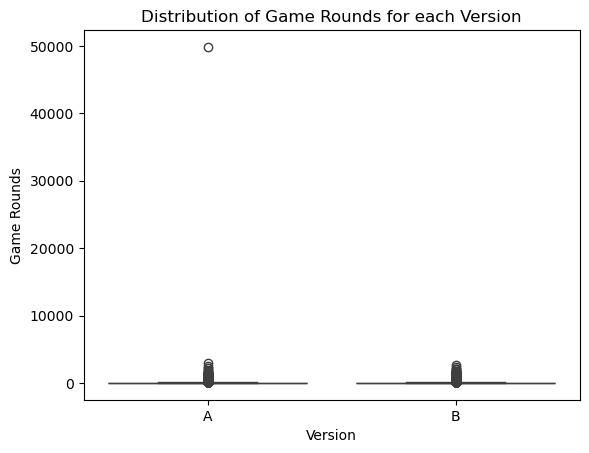

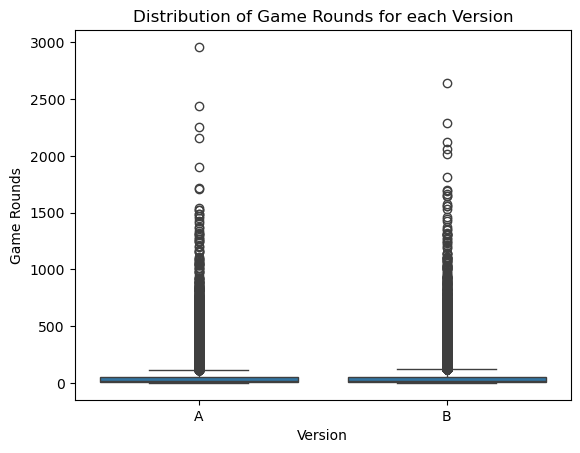

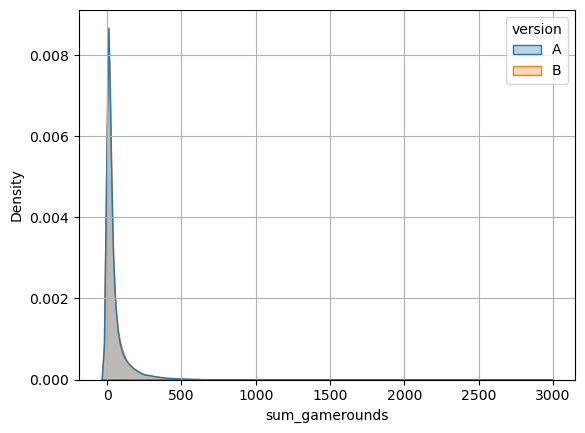

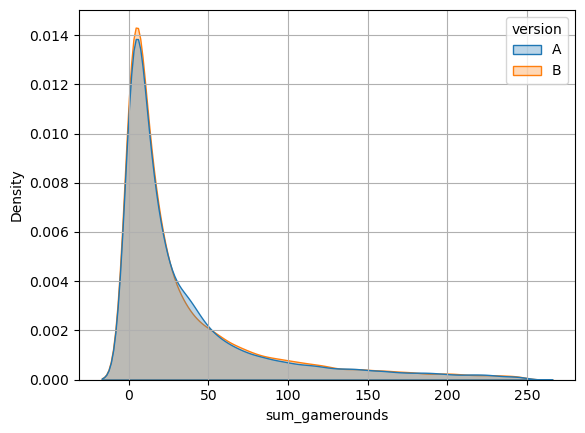

In [101]:
def create_dist_plots():
    sns.boxplot(data=df, x="version", y="sum_gamerounds")
    plt.title("Distribution of Game Rounds for each Version")
    plt.xlabel("Version")
    plt.ylabel("Game Rounds")
    plt.show()
    
create_dist_plots() # one major outlier
df = df[df["sum_gamerounds"] < 30000]
create_dist_plots()
sns.kdeplot(data=df, x="sum_gamerounds", hue="version", fill=True, alpha=0.3)
plt.grid()
plt.show()
sns.kdeplot(data=df[df["sum_gamerounds"] < 250], x="sum_gamerounds", hue="version", fill=True, alpha=0.3)
plt.grid()
plt.show()

In [102]:
def AB_Test(dataframe, group, target):
    
    from scipy.stats import shapiro
    import scipy.stats as stats

    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar", "A/B groups are not similar")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp

In [103]:
AB_Test(dataframe=df, group="version", target="sum_gamerounds")

A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.050892,A/B groups are similar
